In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from baselines.cnn import cnn

2023-07-22 21:59:53.794848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 21:59:55.375372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Preprocess

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


In [6]:
train_X_mask = train_X_mask[:, :n_hours, :]
val_X_mask = val_X_mask[:, :n_hours, :]
test_X_mask = test_X_mask[:, :n_hours, :]

In [7]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 72, 16) (9634, 72, 16) (19268, 72, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [10]:
# ===== model parameters ======
input_shape = train_X_mask.shape[1:]
cnn_unit1 = 64
cnn_unit2 = 32
cnn_unit3 = 16
dropout = 0.1
kernel_size = 2
pool_size=2,
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

In [11]:
model = cnn(input_shape=input_shape,
            cnn_unit1=cnn_unit1,
            cnn_unit2=cnn_unit2,
            cnn_unit3=cnn_unit3,
            dropout=dropout,
            kernel_size=kernel_size,
            pool_size=pool_size,
            masked_value=masked_value
            )
model.summary()

2023-07-22 22:01:56.126202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 16)]          0         
                                                                 
 masking (Masking)           (None, 72, 16)            0         
                                                                 
 conv1d (Conv1D)             (None, 72, 64)            2112      
                                                                 
 max_pooling1d (MaxPooling1  (None, 36, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 36, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 32)            4128      
                                                             

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/cnn_gate_pump_nofuture.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit([train_X_mask], train_ws_y,
          validation_data=([test_X_mask], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-22 22:02:13.725298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-22 22:02:14.718723: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3b0c01aef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-22 22:02:14.718776: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-22 22:02:14.729007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-22 22:02:15.123624: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.17250, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 7s - loss: 0.0797 - mae: 0.2303 - val_loss: 0.0449 - val_mae: 0.1725 - 7s/epoch - 47ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.17250 to 0.15991, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 0.0177 - mae: 0.1107 - val_loss: 0.0378 - val_mae: 0.1599 - 982ms/epoch - 7ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.15991 to 0.15340, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 0.0156 - mae: 0.1046 - val_loss: 0.0347 - val_mae: 0.1534 - 963ms/epoch - 6ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.15340 to 0.13910, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 0.0141 - mae: 0.0990 - val_loss: 0.0286 - val_mae: 0.1391 - 938ms/epoch - 6ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.13910 to 0.11964, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 0.0116 - mae: 0.0884 - val_loss: 0.0216 - val_mae: 0.1196 - 973ms/epoch - 6ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.11964 to 0.10174, saving model to saved_models/cnn_gate_pump_nofuture.

151/151 - 1s - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0042 - val_mae: 0.0510 - 969ms/epoch - 6ms/step
Epoch 41/3000

Epoch 41: val_mae improved from 0.05105 to 0.05025, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 0.0012 - mae: 0.0258 - val_loss: 0.0040 - val_mae: 0.0503 - 954ms/epoch - 6ms/step
Epoch 42/3000

Epoch 42: val_mae improved from 0.05025 to 0.04950, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 0.0012 - mae: 0.0256 - val_loss: 0.0039 - val_mae: 0.0495 - 985ms/epoch - 7ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.04950 to 0.04874, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 0.0011 - mae: 0.0254 - val_loss: 0.0038 - val_mae: 0.0487 - 989ms/epoch - 7ms/step
Epoch 44/3000

Epoch 44: val_mae improved from 0.04874 to 0.04851, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 0.0011 - mae: 0.0253 - val_loss: 0.0038 - val_mae: 0.0485 - 953ms/epoch - 6

Epoch 83/3000

Epoch 83: val_mae did not improve from 0.04275
151/151 - 1s - loss: 8.4457e-04 - mae: 0.0214 - val_loss: 0.0030 - val_mae: 0.0429 - 918ms/epoch - 6ms/step
Epoch 84/3000

Epoch 84: val_mae did not improve from 0.04275
151/151 - 1s - loss: 8.4170e-04 - mae: 0.0214 - val_loss: 0.0031 - val_mae: 0.0443 - 989ms/epoch - 7ms/step
Epoch 85/3000

Epoch 85: val_mae did not improve from 0.04275
151/151 - 1s - loss: 8.3783e-04 - mae: 0.0213 - val_loss: 0.0030 - val_mae: 0.0434 - 930ms/epoch - 6ms/step
Epoch 86/3000

Epoch 86: val_mae did not improve from 0.04275
151/151 - 1s - loss: 8.3468e-04 - mae: 0.0213 - val_loss: 0.0030 - val_mae: 0.0437 - 926ms/epoch - 6ms/step
Epoch 87/3000

Epoch 87: val_mae did not improve from 0.04275
151/151 - 1s - loss: 8.3167e-04 - mae: 0.0212 - val_loss: 0.0031 - val_mae: 0.0444 - 907ms/epoch - 6ms/step
Epoch 88/3000

Epoch 88: val_mae improved from 0.04275 to 0.04268, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 8.2845e

Epoch 130/3000

Epoch 130: val_mae did not improve from 0.04245
151/151 - 1s - loss: 7.1132e-04 - mae: 0.0197 - val_loss: 0.0029 - val_mae: 0.0426 - 915ms/epoch - 6ms/step
Epoch 131/3000

Epoch 131: val_mae did not improve from 0.04245
151/151 - 1s - loss: 7.0850e-04 - mae: 0.0197 - val_loss: 0.0029 - val_mae: 0.0428 - 924ms/epoch - 6ms/step
Epoch 132/3000

Epoch 132: val_mae did not improve from 0.04245
151/151 - 1s - loss: 7.0663e-04 - mae: 0.0196 - val_loss: 0.0030 - val_mae: 0.0433 - 900ms/epoch - 6ms/step
Epoch 133/3000

Epoch 133: val_mae did not improve from 0.04245
151/151 - 1s - loss: 7.0523e-04 - mae: 0.0196 - val_loss: 0.0029 - val_mae: 0.0426 - 915ms/epoch - 6ms/step
Epoch 134/3000

Epoch 134: val_mae improved from 0.04245 to 0.04186, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 7.0349e-04 - mae: 0.0196 - val_loss: 0.0028 - val_mae: 0.0419 - 959ms/epoch - 6ms/step
Epoch 135/3000

Epoch 135: val_mae did not improve from 0.04186
151/151 - 1s - l

Epoch 177/3000

Epoch 177: val_mae did not improve from 0.04150
151/151 - 1s - loss: 6.5251e-04 - mae: 0.0188 - val_loss: 0.0029 - val_mae: 0.0421 - 932ms/epoch - 6ms/step
Epoch 178/3000

Epoch 178: val_mae did not improve from 0.04150
151/151 - 1s - loss: 6.5256e-04 - mae: 0.0188 - val_loss: 0.0028 - val_mae: 0.0419 - 922ms/epoch - 6ms/step
Epoch 179/3000

Epoch 179: val_mae did not improve from 0.04150
151/151 - 1s - loss: 6.5328e-04 - mae: 0.0188 - val_loss: 0.0030 - val_mae: 0.0429 - 909ms/epoch - 6ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.04150
151/151 - 1s - loss: 6.5294e-04 - mae: 0.0188 - val_loss: 0.0028 - val_mae: 0.0418 - 932ms/epoch - 6ms/step
Epoch 181/3000

Epoch 181: val_mae improved from 0.04150 to 0.04104, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 6.5124e-04 - mae: 0.0188 - val_loss: 0.0027 - val_mae: 0.0410 - 966ms/epoch - 6ms/step
Epoch 182/3000

Epoch 182: val_mae did not improve from 0.04104
151/151 - 1s - l

Epoch 223/3000

Epoch 223: val_mae did not improve from 0.04089
151/151 - 1s - loss: 6.2658e-04 - mae: 0.0184 - val_loss: 0.0028 - val_mae: 0.0416 - 940ms/epoch - 6ms/step
Epoch 224/3000

Epoch 224: val_mae did not improve from 0.04089
151/151 - 1s - loss: 6.2572e-04 - mae: 0.0184 - val_loss: 0.0029 - val_mae: 0.0424 - 924ms/epoch - 6ms/step
Epoch 225/3000

Epoch 225: val_mae did not improve from 0.04089
151/151 - 1s - loss: 6.2417e-04 - mae: 0.0184 - val_loss: 0.0030 - val_mae: 0.0426 - 919ms/epoch - 6ms/step
Epoch 226/3000

Epoch 226: val_mae did not improve from 0.04089
151/151 - 1s - loss: 6.2539e-04 - mae: 0.0184 - val_loss: 0.0029 - val_mae: 0.0420 - 917ms/epoch - 6ms/step
Epoch 227/3000

Epoch 227: val_mae did not improve from 0.04089
151/151 - 1s - loss: 6.2350e-04 - mae: 0.0184 - val_loss: 0.0029 - val_mae: 0.0418 - 934ms/epoch - 6ms/step
Epoch 228/3000

Epoch 228: val_mae did not improve from 0.04089
151/151 - 1s - loss: 6.2391e-04 - mae: 0.0184 - val_loss: 0.0029 - val_mae: 

Epoch 270/3000

Epoch 270: val_mae did not improve from 0.04041
151/151 - 1s - loss: 6.0570e-04 - mae: 0.0181 - val_loss: 0.0027 - val_mae: 0.0407 - 938ms/epoch - 6ms/step
Epoch 271/3000

Epoch 271: val_mae did not improve from 0.04041
151/151 - 1s - loss: 6.0622e-04 - mae: 0.0181 - val_loss: 0.0029 - val_mae: 0.0416 - 917ms/epoch - 6ms/step
Epoch 272/3000

Epoch 272: val_mae did not improve from 0.04041
151/151 - 1s - loss: 6.0458e-04 - mae: 0.0180 - val_loss: 0.0027 - val_mae: 0.0405 - 922ms/epoch - 6ms/step
Epoch 273/3000

Epoch 273: val_mae did not improve from 0.04041
151/151 - 1s - loss: 6.0578e-04 - mae: 0.0181 - val_loss: 0.0028 - val_mae: 0.0415 - 915ms/epoch - 6ms/step
Epoch 274/3000

Epoch 274: val_mae did not improve from 0.04041
151/151 - 1s - loss: 6.0448e-04 - mae: 0.0180 - val_loss: 0.0027 - val_mae: 0.0408 - 941ms/epoch - 6ms/step
Epoch 275/3000

Epoch 275: val_mae did not improve from 0.04041
151/151 - 1s - loss: 6.0473e-04 - mae: 0.0180 - val_loss: 0.0028 - val_mae: 

Epoch 317/3000

Epoch 317: val_mae improved from 0.04021 to 0.03990, saving model to saved_models/cnn_gate_pump_nofuture.h5
151/151 - 1s - loss: 5.9147e-04 - mae: 0.0178 - val_loss: 0.0027 - val_mae: 0.0399 - 967ms/epoch - 6ms/step
Epoch 318/3000

Epoch 318: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.8986e-04 - mae: 0.0178 - val_loss: 0.0028 - val_mae: 0.0414 - 915ms/epoch - 6ms/step
Epoch 319/3000

Epoch 319: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.9021e-04 - mae: 0.0178 - val_loss: 0.0029 - val_mae: 0.0417 - 911ms/epoch - 6ms/step
Epoch 320/3000

Epoch 320: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.8997e-04 - mae: 0.0178 - val_loss: 0.0027 - val_mae: 0.0405 - 958ms/epoch - 6ms/step
Epoch 321/3000

Epoch 321: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.8976e-04 - mae: 0.0178 - val_loss: 0.0029 - val_mae: 0.0417 - 924ms/epoch - 6ms/step
Epoch 322/3000

Epoch 322: val_mae did not improve from 0.03990
151/151 - 1s - l

151/151 - 1s - loss: 5.7961e-04 - mae: 0.0176 - val_loss: 0.0029 - val_mae: 0.0415 - 912ms/epoch - 6ms/step
Epoch 365/3000

Epoch 365: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.7873e-04 - mae: 0.0176 - val_loss: 0.0028 - val_mae: 0.0408 - 937ms/epoch - 6ms/step
Epoch 366/3000

Epoch 366: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.7831e-04 - mae: 0.0176 - val_loss: 0.0028 - val_mae: 0.0407 - 924ms/epoch - 6ms/step
Epoch 367/3000

Epoch 367: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.7754e-04 - mae: 0.0176 - val_loss: 0.0027 - val_mae: 0.0405 - 929ms/epoch - 6ms/step
Epoch 368/3000

Epoch 368: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.7847e-04 - mae: 0.0176 - val_loss: 0.0030 - val_mae: 0.0421 - 944ms/epoch - 6ms/step
Epoch 369/3000

Epoch 369: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.7889e-04 - mae: 0.0176 - val_loss: 0.0028 - val_mae: 0.0412 - 950ms/epoch - 6ms/step
Epoch 370/3000

Epoch 370: val_m


Epoch 412: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.7019e-04 - mae: 0.0175 - val_loss: 0.0029 - val_mae: 0.0417 - 947ms/epoch - 6ms/step
Epoch 413/3000

Epoch 413: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.6863e-04 - mae: 0.0175 - val_loss: 0.0028 - val_mae: 0.0406 - 930ms/epoch - 6ms/step
Epoch 414/3000

Epoch 414: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.6897e-04 - mae: 0.0175 - val_loss: 0.0028 - val_mae: 0.0409 - 931ms/epoch - 6ms/step
Epoch 415/3000

Epoch 415: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.6948e-04 - mae: 0.0175 - val_loss: 0.0028 - val_mae: 0.0405 - 958ms/epoch - 6ms/step
Epoch 416/3000

Epoch 416: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.6815e-04 - mae: 0.0174 - val_loss: 0.0029 - val_mae: 0.0414 - 924ms/epoch - 6ms/step
Epoch 417/3000

Epoch 417: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.6834e-04 - mae: 0.0174 - val_loss: 0.0029 - val_mae: 0.0418 - 915ms/

Epoch 460/3000

Epoch 460: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.6245e-04 - mae: 0.0174 - val_loss: 0.0028 - val_mae: 0.0409 - 958ms/epoch - 6ms/step
Epoch 461/3000

Epoch 461: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.6161e-04 - mae: 0.0173 - val_loss: 0.0028 - val_mae: 0.0407 - 953ms/epoch - 6ms/step
Epoch 462/3000

Epoch 462: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.6120e-04 - mae: 0.0173 - val_loss: 0.0029 - val_mae: 0.0412 - 930ms/epoch - 6ms/step
Epoch 463/3000

Epoch 463: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.6123e-04 - mae: 0.0173 - val_loss: 0.0028 - val_mae: 0.0404 - 913ms/epoch - 6ms/step
Epoch 464/3000

Epoch 464: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.6097e-04 - mae: 0.0173 - val_loss: 0.0028 - val_mae: 0.0410 - 912ms/epoch - 6ms/step
Epoch 465/3000

Epoch 465: val_mae did not improve from 0.03990
151/151 - 1s - loss: 5.5999e-04 - mae: 0.0173 - val_loss: 0.0028 - val_mae: 

151/151 - 1s - loss: 5.5544e-04 - mae: 0.0172 - val_loss: 0.0027 - val_mae: 0.0403 - 937ms/epoch - 6ms/step
Epoch 508/3000

Epoch 508: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.5573e-04 - mae: 0.0172 - val_loss: 0.0028 - val_mae: 0.0404 - 981ms/epoch - 6ms/step
Epoch 509/3000

Epoch 509: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.5484e-04 - mae: 0.0172 - val_loss: 0.0028 - val_mae: 0.0406 - 934ms/epoch - 6ms/step
Epoch 510/3000

Epoch 510: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.5362e-04 - mae: 0.0172 - val_loss: 0.0028 - val_mae: 0.0406 - 927ms/epoch - 6ms/step
Epoch 511/3000

Epoch 511: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.5472e-04 - mae: 0.0172 - val_loss: 0.0029 - val_mae: 0.0411 - 950ms/epoch - 6ms/step
Epoch 512/3000

Epoch 512: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.5442e-04 - mae: 0.0172 - val_loss: 0.0027 - val_mae: 0.0400 - 927ms/epoch - 6ms/step
Epoch 513/3000

Epoch 513: val_m


Epoch 555: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.5075e-04 - mae: 0.0172 - val_loss: 0.0027 - val_mae: 0.0396 - 932ms/epoch - 6ms/step
Epoch 556/3000

Epoch 556: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.5090e-04 - mae: 0.0172 - val_loss: 0.0027 - val_mae: 0.0400 - 921ms/epoch - 6ms/step
Epoch 557/3000

Epoch 557: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.4943e-04 - mae: 0.0171 - val_loss: 0.0028 - val_mae: 0.0407 - 928ms/epoch - 6ms/step
Epoch 558/3000

Epoch 558: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.4946e-04 - mae: 0.0171 - val_loss: 0.0029 - val_mae: 0.0416 - 935ms/epoch - 6ms/step
Epoch 559/3000

Epoch 559: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.5057e-04 - mae: 0.0172 - val_loss: 0.0027 - val_mae: 0.0399 - 957ms/epoch - 6ms/step
Epoch 560/3000

Epoch 560: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.4960e-04 - mae: 0.0171 - val_loss: 0.0028 - val_mae: 0.0403 - 914ms/

Epoch 603/3000

Epoch 603: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.4541e-04 - mae: 0.0171 - val_loss: 0.0028 - val_mae: 0.0403 - 917ms/epoch - 6ms/step
Epoch 604/3000

Epoch 604: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.4561e-04 - mae: 0.0171 - val_loss: 0.0028 - val_mae: 0.0408 - 939ms/epoch - 6ms/step
Epoch 605/3000

Epoch 605: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.4571e-04 - mae: 0.0171 - val_loss: 0.0027 - val_mae: 0.0396 - 918ms/epoch - 6ms/step
Epoch 606/3000

Epoch 606: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.4499e-04 - mae: 0.0171 - val_loss: 0.0027 - val_mae: 0.0396 - 919ms/epoch - 6ms/step
Epoch 607/3000

Epoch 607: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.4441e-04 - mae: 0.0170 - val_loss: 0.0028 - val_mae: 0.0404 - 937ms/epoch - 6ms/step
Epoch 608/3000

Epoch 608: val_mae did not improve from 0.03950
151/151 - 1s - loss: 5.4410e-04 - mae: 0.0170 - val_loss: 0.0027 - val_mae: 

151/151 - 1s - loss: 5.4092e-04 - mae: 0.0170 - val_loss: 0.0027 - val_mae: 0.0401 - 937ms/epoch - 6ms/step
Epoch 651/3000

Epoch 651: val_mae did not improve from 0.03908
151/151 - 1s - loss: 5.4025e-04 - mae: 0.0170 - val_loss: 0.0027 - val_mae: 0.0396 - 944ms/epoch - 6ms/step
Epoch 652/3000

Epoch 652: val_mae did not improve from 0.03908
151/151 - 1s - loss: 5.4146e-04 - mae: 0.0170 - val_loss: 0.0027 - val_mae: 0.0400 - 970ms/epoch - 6ms/step
Epoch 653/3000

Epoch 653: val_mae did not improve from 0.03908
151/151 - 1s - loss: 5.4051e-04 - mae: 0.0170 - val_loss: 0.0027 - val_mae: 0.0397 - 945ms/epoch - 6ms/step
Epoch 654/3000

Epoch 654: val_mae did not improve from 0.03908
151/151 - 1s - loss: 5.4052e-04 - mae: 0.0170 - val_loss: 0.0027 - val_mae: 0.0397 - 939ms/epoch - 6ms/step
Epoch 655/3000

Epoch 655: val_mae did not improve from 0.03908
151/151 - 1s - loss: 5.4003e-04 - mae: 0.0170 - val_loss: 0.0027 - val_mae: 0.0401 - 940ms/epoch - 6ms/step
Epoch 656/3000

Epoch 656: val_m

Epoch 697/3000

Epoch 697: val_mae did not improve from 0.03883
151/151 - 1s - loss: 5.3736e-04 - mae: 0.0169 - val_loss: 0.0027 - val_mae: 0.0396 - 935ms/epoch - 6ms/step
Epoch 698/3000

Epoch 698: val_mae did not improve from 0.03883
151/151 - 1s - loss: 5.3778e-04 - mae: 0.0169 - val_loss: 0.0027 - val_mae: 0.0395 - 911ms/epoch - 6ms/step
Epoch 699/3000

Epoch 699: val_mae did not improve from 0.03883
151/151 - 1s - loss: 5.3716e-04 - mae: 0.0169 - val_loss: 0.0027 - val_mae: 0.0395 - 927ms/epoch - 6ms/step
Epoch 700/3000

Epoch 700: val_mae did not improve from 0.03883
151/151 - 1s - loss: 5.3726e-04 - mae: 0.0169 - val_loss: 0.0026 - val_mae: 0.0394 - 935ms/epoch - 6ms/step
Epoch 701/3000

Epoch 701: val_mae did not improve from 0.03883
151/151 - 1s - loss: 5.3703e-04 - mae: 0.0169 - val_loss: 0.0026 - val_mae: 0.0391 - 952ms/epoch - 6ms/step
Epoch 702/3000

Epoch 702: val_mae did not improve from 0.03883
151/151 - 1s - loss: 5.3787e-04 - mae: 0.0169 - val_loss: 0.0026 - val_mae: 

151/151 - 1s - loss: 5.3442e-04 - mae: 0.0169 - val_loss: 0.0026 - val_mae: 0.0387 - 970ms/epoch - 6ms/step
Epoch 745/3000

Epoch 745: val_mae did not improve from 0.03866
151/151 - 1s - loss: 5.3504e-04 - mae: 0.0169 - val_loss: 0.0026 - val_mae: 0.0387 - 916ms/epoch - 6ms/step
Epoch 746/3000

Epoch 746: val_mae did not improve from 0.03866
151/151 - 1s - loss: 5.3351e-04 - mae: 0.0169 - val_loss: 0.0026 - val_mae: 0.0390 - 925ms/epoch - 6ms/step
Epoch 747/3000

Epoch 747: val_mae did not improve from 0.03866
151/151 - 1s - loss: 5.3373e-04 - mae: 0.0169 - val_loss: 0.0026 - val_mae: 0.0391 - 919ms/epoch - 6ms/step
Epoch 748/3000

Epoch 748: val_mae did not improve from 0.03866
151/151 - 1s - loss: 5.3355e-04 - mae: 0.0169 - val_loss: 0.0027 - val_mae: 0.0394 - 924ms/epoch - 6ms/step
Epoch 749/3000

Epoch 749: val_mae did not improve from 0.03866
151/151 - 1s - loss: 5.3381e-04 - mae: 0.0169 - val_loss: 0.0026 - val_mae: 0.0391 - 912ms/epoch - 6ms/step
Epoch 750/3000

Epoch 750: val_m

Epoch 792/3000

Epoch 792: val_mae did not improve from 0.03862
151/151 - 1s - loss: 5.3089e-04 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0389 - 950ms/epoch - 6ms/step
Epoch 793/3000

Epoch 793: val_mae did not improve from 0.03862
151/151 - 1s - loss: 5.3076e-04 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0392 - 939ms/epoch - 6ms/step
Epoch 794/3000

Epoch 794: val_mae did not improve from 0.03862
151/151 - 1s - loss: 5.3100e-04 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0393 - 949ms/epoch - 6ms/step
Epoch 795/3000

Epoch 795: val_mae did not improve from 0.03862
151/151 - 1s - loss: 5.3061e-04 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0388 - 957ms/epoch - 6ms/step
Epoch 796/3000

Epoch 796: val_mae did not improve from 0.03862
151/151 - 1s - loss: 5.3000e-04 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0390 - 936ms/epoch - 6ms/step
Epoch 797/3000

Epoch 797: val_mae did not improve from 0.03862
151/151 - 1s - loss: 5.3107e-04 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 

151/151 - 1s - loss: 5.2814e-04 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0393 - 949ms/epoch - 6ms/step
Epoch 840/3000

Epoch 840: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2806e-04 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0389 - 955ms/epoch - 6ms/step
Epoch 841/3000

Epoch 841: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2851e-04 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0391 - 928ms/epoch - 6ms/step
Epoch 842/3000

Epoch 842: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2831e-04 - mae: 0.0168 - val_loss: 0.0026 - val_mae: 0.0390 - 917ms/epoch - 6ms/step
Epoch 843/3000

Epoch 843: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2775e-04 - mae: 0.0168 - val_loss: 0.0027 - val_mae: 0.0393 - 934ms/epoch - 6ms/step
Epoch 844/3000

Epoch 844: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2845e-04 - mae: 0.0168 - val_loss: 0.0027 - val_mae: 0.0395 - 969ms/epoch - 6ms/step
Epoch 845/3000

Epoch 845: val_m

Epoch 887/3000

Epoch 887: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2629e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 0.0392 - 935ms/epoch - 6ms/step
Epoch 888/3000

Epoch 888: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2661e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 0.0391 - 931ms/epoch - 6ms/step
Epoch 889/3000

Epoch 889: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2491e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 0.0393 - 961ms/epoch - 6ms/step
Epoch 890/3000

Epoch 890: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2561e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 0.0387 - 967ms/epoch - 6ms/step
Epoch 891/3000

Epoch 891: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2553e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 0.0389 - 975ms/epoch - 6ms/step
Epoch 892/3000

Epoch 892: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2516e-04 - mae: 0.0167 - val_loss: 0.0027 - val_mae: 

Epoch 935/3000

Epoch 935: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2321e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 0.0392 - 918ms/epoch - 6ms/step
Epoch 936/3000

Epoch 936: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2367e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 0.0391 - 921ms/epoch - 6ms/step
Epoch 937/3000

Epoch 937: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2389e-04 - mae: 0.0167 - val_loss: 0.0027 - val_mae: 0.0395 - 938ms/epoch - 6ms/step
Epoch 938/3000

Epoch 938: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2419e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 0.0390 - 926ms/epoch - 6ms/step
Epoch 939/3000

Epoch 939: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2352e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 0.0391 - 924ms/epoch - 6ms/step
Epoch 940/3000

Epoch 940: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2381e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 

Epoch 983/3000

Epoch 983: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2216e-04 - mae: 0.0167 - val_loss: 0.0027 - val_mae: 0.0394 - 953ms/epoch - 6ms/step
Epoch 984/3000

Epoch 984: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2022e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0395 - 977ms/epoch - 6ms/step
Epoch 985/3000

Epoch 985: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2091e-04 - mae: 0.0166 - val_loss: 0.0026 - val_mae: 0.0390 - 924ms/epoch - 6ms/step
Epoch 986/3000

Epoch 986: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2121e-04 - mae: 0.0167 - val_loss: 0.0026 - val_mae: 0.0390 - 924ms/epoch - 6ms/step
Epoch 987/3000

Epoch 987: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2102e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0393 - 967ms/epoch - 6ms/step
Epoch 988/3000

Epoch 988: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.2168e-04 - mae: 0.0167 - val_loss: 0.0027 - val_mae: 

151/151 - 1s - loss: 5.1878e-04 - mae: 0.0166 - val_loss: 0.0026 - val_mae: 0.0391 - 920ms/epoch - 6ms/step
Epoch 1031/3000

Epoch 1031: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1944e-04 - mae: 0.0166 - val_loss: 0.0026 - val_mae: 0.0392 - 944ms/epoch - 6ms/step
Epoch 1032/3000

Epoch 1032: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1976e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0393 - 921ms/epoch - 6ms/step
Epoch 1033/3000

Epoch 1033: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1944e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0395 - 923ms/epoch - 6ms/step
Epoch 1034/3000

Epoch 1034: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1947e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0394 - 921ms/epoch - 6ms/step
Epoch 1035/3000

Epoch 1035: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1900e-04 - mae: 0.0166 - val_loss: 0.0026 - val_mae: 0.0390 - 941ms/epoch - 6ms/step
Epoch 1036/3000

Epoch

Epoch 1078/3000

Epoch 1078: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1682e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0395 - 927ms/epoch - 6ms/step
Epoch 1079/3000

Epoch 1079: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1779e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0394 - 923ms/epoch - 6ms/step
Epoch 1080/3000

Epoch 1080: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1786e-04 - mae: 0.0166 - val_loss: 0.0026 - val_mae: 0.0393 - 926ms/epoch - 6ms/step
Epoch 1081/3000

Epoch 1081: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1821e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0396 - 918ms/epoch - 6ms/step
Epoch 1082/3000

Epoch 1082: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1784e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0399 - 939ms/epoch - 6ms/step
Epoch 1083/3000

Epoch 1083: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1723e-04 - mae: 0.0166 - val_loss: 0.0027


Epoch 1125: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1604e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0397 - 948ms/epoch - 6ms/step
Epoch 1126/3000

Epoch 1126: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1641e-04 - mae: 0.0166 - val_loss: 0.0026 - val_mae: 0.0390 - 965ms/epoch - 6ms/step
Epoch 1127/3000

Epoch 1127: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1642e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0395 - 931ms/epoch - 6ms/step
Epoch 1128/3000

Epoch 1128: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1611e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0394 - 933ms/epoch - 6ms/step
Epoch 1129/3000

Epoch 1129: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1582e-04 - mae: 0.0166 - val_loss: 0.0026 - val_mae: 0.0393 - 940ms/epoch - 6ms/step
Epoch 1130/3000

Epoch 1130: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1674e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.03

151/151 - 1s - loss: 5.1551e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0396 - 945ms/epoch - 6ms/step
Epoch 1173/3000

Epoch 1173: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1441e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0394 - 921ms/epoch - 6ms/step
Epoch 1174/3000

Epoch 1174: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1456e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0394 - 932ms/epoch - 6ms/step
Epoch 1175/3000

Epoch 1175: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1349e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0394 - 947ms/epoch - 6ms/step
Epoch 1176/3000

Epoch 1176: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1536e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0396 - 920ms/epoch - 6ms/step
Epoch 1177/3000

Epoch 1177: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1443e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0394 - 941ms/epoch - 6ms/step
Epoch 1178/3000

Epoch

Epoch 1220/3000

Epoch 1220: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1261e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0398 - 921ms/epoch - 6ms/step
Epoch 1221/3000

Epoch 1221: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1355e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0398 - 920ms/epoch - 6ms/step
Epoch 1222/3000

Epoch 1222: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1278e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0399 - 931ms/epoch - 6ms/step
Epoch 1223/3000

Epoch 1223: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1355e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0395 - 939ms/epoch - 6ms/step
Epoch 1224/3000

Epoch 1224: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1259e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0397 - 902ms/epoch - 6ms/step
Epoch 1225/3000

Epoch 1225: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1292e-04 - mae: 0.0165 - val_loss: 0.0027


Epoch 1267: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1185e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0400 - 974ms/epoch - 6ms/step
Epoch 1268/3000

Epoch 1268: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1188e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0395 - 969ms/epoch - 6ms/step
Epoch 1269/3000

Epoch 1269: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1161e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0398 - 963ms/epoch - 6ms/step
Epoch 1270/3000

Epoch 1270: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1113e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0398 - 962ms/epoch - 6ms/step
Epoch 1271/3000

Epoch 1271: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1045e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0396 - 950ms/epoch - 6ms/step
Epoch 1272/3000

Epoch 1272: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1162e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.03

151/151 - 1s - loss: 5.0991e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0397 - 952ms/epoch - 6ms/step
Epoch 1315/3000

Epoch 1315: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1017e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0396 - 916ms/epoch - 6ms/step
Epoch 1316/3000

Epoch 1316: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.0971e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0398 - 947ms/epoch - 6ms/step
Epoch 1317/3000

Epoch 1317: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1089e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0396 - 946ms/epoch - 6ms/step
Epoch 1318/3000

Epoch 1318: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1024e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0396 - 920ms/epoch - 6ms/step
Epoch 1319/3000

Epoch 1319: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.1094e-04 - mae: 0.0165 - val_loss: 0.0027 - val_mae: 0.0400 - 908ms/epoch - 6ms/step
Epoch 1320/3000

Epoch

Epoch 1362/3000

Epoch 1362: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.0824e-04 - mae: 0.0164 - val_loss: 0.0027 - val_mae: 0.0399 - 924ms/epoch - 6ms/step
Epoch 1363/3000

Epoch 1363: val_mae did not improve from 0.03853
151/151 - 1s - loss: 5.0776e-04 - mae: 0.0164 - val_loss: 0.0027 - val_mae: 0.0400 - 925ms/epoch - 6ms/step
Epoch 1363: early stopping


### Performance

In [13]:
saved_model = load_model('saved_models/cnn_gate_pump_nofuture.h5')

yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 1s 2ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.203
RMSE = 0.2656


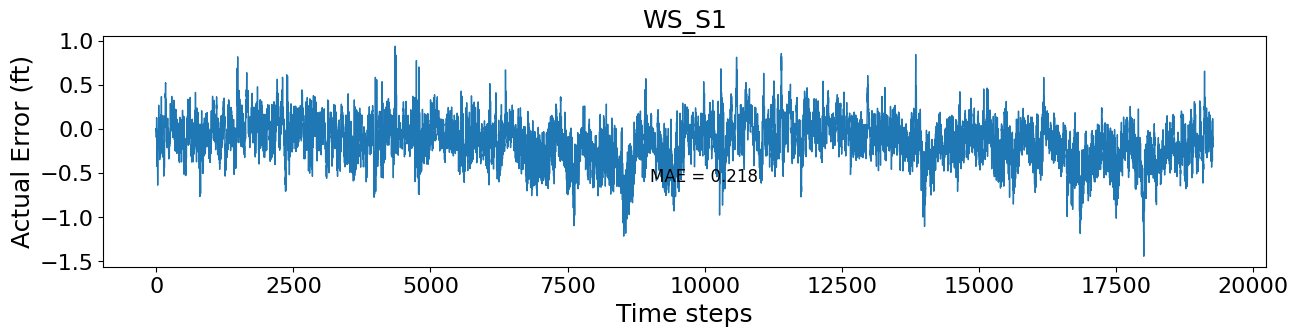

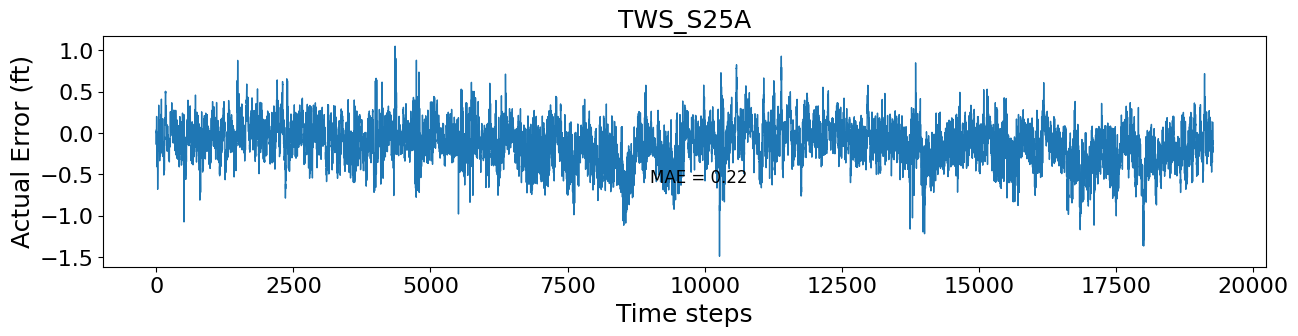

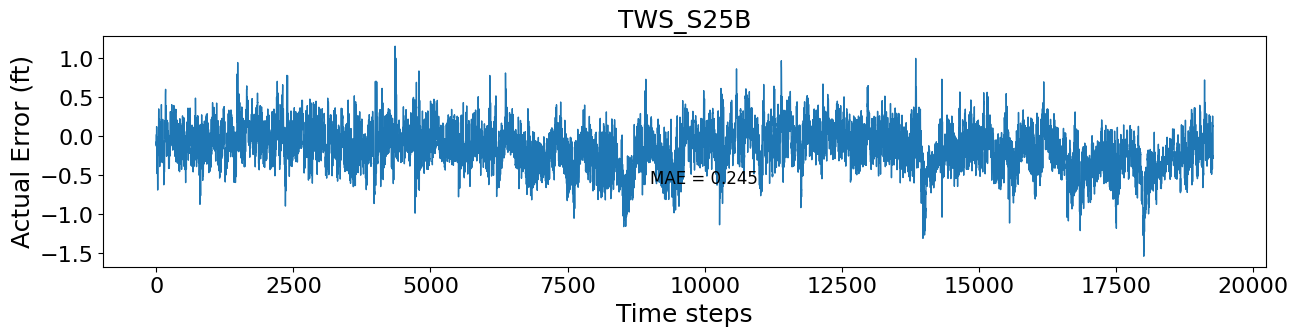

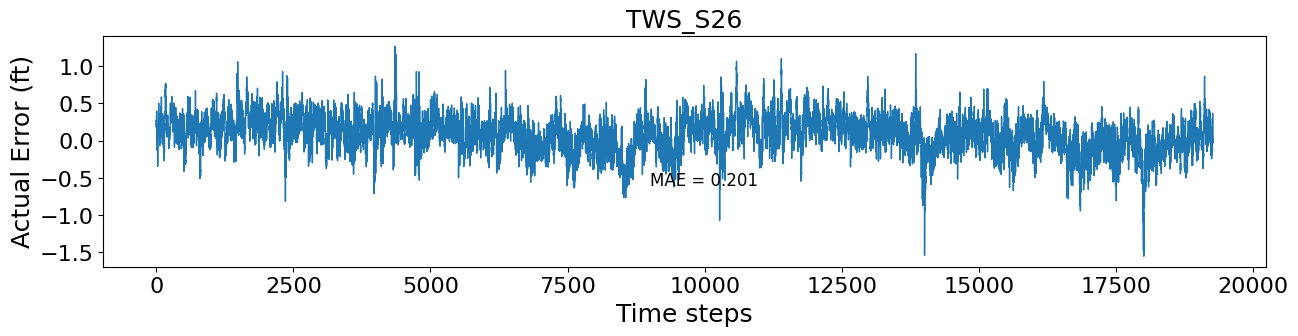

In [14]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [15]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
1478
(19268,)
1495
(19268,)
1973
(19268,)
931


In [16]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
92
(19268,)
114
(19268,)
168
(19268,)
659


In [17]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
1386
(19268,)
1381
(19268,)
1805
(19268,)
272
